In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from collections import OrderedDict
mnist_sci = fetch_openml('mnist_784')

In [40]:
%load_ext watermark
%watermark -u -d -p numpy,pandas,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: 2020-06-09 

numpy 1.18.3
pandas 1.0.3
matplotlib 3.2.1
sklearn 0.0


**NOTE** 코딩해야할 부분을 제외하고는 수정하지 마세요.

# DATA LOAD

In [41]:
mnist_sci = fetch_openml('mnist_784')

In [42]:
x_train, x_test, y_train_, y_test_ = train_test_split(mnist_sci.data, mnist_sci.target, 
                                                    test_size = 0.1,
                                                   shuffle = True)
x_train /= 255.0
x_test /= 255.0

def one_hoy_label(X):
    T = np.zeros((X.size, 10))    
    for idx, row in enumerate(T):
        row[int(X[idx])] = 1
        
    return T

y_train = one_hoy_label(y_train_)
y_test = one_hoy_label(y_test_)


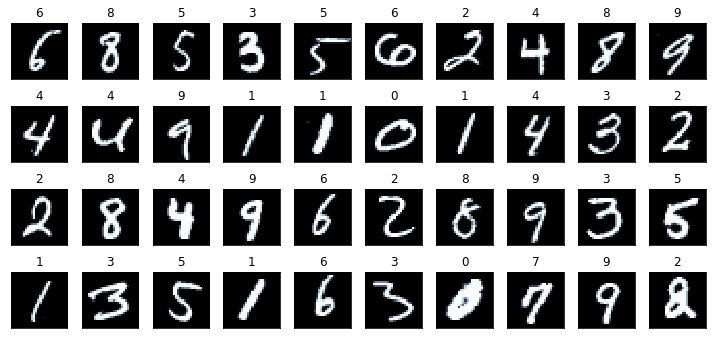

In [43]:
N = 4
M = 10
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i*M+j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(x_train[k].reshape(28,28), cmap=plt.cm.bone, interpolation="none")
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title(y_train_[k])
plt.tight_layout()
plt.show()

## functions

In [44]:
class Softmax_CE:
    """
    편의를 위해서 softmax와 crossenropy를 결합한 것입니다.
    """
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = CE_loss(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx
    

#179 페이지,softmaxwithloss

In [45]:
def softmax(x):
     ######################################################################
    # 문제 1-1 softmax 함수를 구현하세요                                 #
    ######################################################################
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

$$ CE = \frac{1}{N_{batch}} \sum(log(y, t))$$ 

In [46]:
def CE_loss(y, t):
     ######################################################################
    # 문제 1-2 cross entropy 함수를 구현하세요.                               
    # y 값의 경우 예측한 값, t값의 경우 true label 값입니다.    
    # batch 로 데이터가 들어온다는 것을 유의 하세요.
    ######################################################################
  
    if y.ndim==1:
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
        
        batch_size=y.shape[0]
    
        return -np.sum(t*np.log(y+1e-7))/batch_size
    
     ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [47]:
class Relu:
    ######################################################################
    # 문제 1-3 Rely layer 를 구현하세요                                  #
    # 출력값이 0이 되는 부분과 아닌 부분에 대해서 잘 생각해보세요        #
    ######################################################################
    
    # masking을 해보세요
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask=(x<=0)
        out=x.copy()
        out[self.mask]=0
        return out
    # mask는 True/false로 구성된 넘파이 배열로 x의 원소가 0이하면 True아니면 false를 반환
    # 항등항수의 미분은 자기 자신입니다. 
    def backward(self, dout):
        dout[self.mask]=0
        dx=dout

        return dx
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

In [48]:
class FClayer:
    
     ######################################################################
    # 문제 1-4 fully connecter layer 를 완성하세요                       #
    # 행렬의 곱셈에 대한 backward를 신중히 구현하세요                    #
    ######################################################################
   
    def __init__(self, W, b):
        
        self.W = W
        self.b = b
        self.x = None
        
        # backward 를 위해서 shape을 변경할 수가 있어서 원래의 shape 저장
        
        
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 본인이 구현한 입력 이미지의 shape 에 따라서 조정을 해줄수도 있습니다. 
        self.x=x
        out=np.dot(x,self.W)+self.b


        return out
    
    # 1차원 함수의 곱셈에 대해서 생각해보고 그것을 확장하세요 
    # 항상 데이터의 shape에 주의 하세요
    def backward(self, dout):
        dx=np.dot(dout,self.W.T)
        self.dW=np.dot(self.x.T,dout)
        self.db=np.sum(dout,axis=0)
        
        
        return dx
    
    ######################################################################
    #                          END OF YOUR CODE                          #
    ######################################################################

#### 이번 과제의 네트워크의 구조는 1개의 히든 레이어를 가진 네트워크 입니다.
#### 활성함수로는 Relu 를 사용하세요 

In [49]:
class DNN:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
         ######################################################################
        # 문제 1-5 파라미터 초기화를 적용하세요                              #
        # 최소한 85% 이상의 test acc가 나올수 있도록 하세요                  #
        # 수업시간에 배운 초기화 방법이 성능이 보통 좋습니다. 
        # 파라미터의 shape에 대해 잘 생각해보세요
        ######################################################################

        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
         
        ######################################################################
        #                          END OF YOUR CODE                          #
        ######################################################################

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['FClayer1'] = FClayer(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['FClayer2'] = FClayer(self.params['W2'], self.params['b2'])

        self.lastLayer = Softmax_CE()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)        
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
       
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['FClayer1'].dW, self.layers['FClayer1'].db
        grads['W2'], grads['b2'] = self.layers['FClayer2'].dW, self.layers['FClayer2'].db

        return grads


epoch	test acc  
    0	0.9047
    1	0.9227
    2	0.9354
    3	0.9450
    4	0.9511
    5	0.9546
    6	0.9560
    7	0.9583
    8	0.9601
    9	0.9607


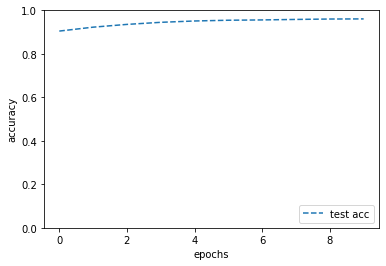

In [50]:
######################################################################
# 문제 1-6 구현한 것을 바탕으로 최종적으로 학습해보세요              #
# 최소한 85% 이상의 test acc가 나올수 있도록 하세요                  #
# 보고서에 print 값과 그래프를 제출하세요                            #
######################################################################

network = DNN(input_size=784, hidden_size=50, output_size=10)

train_size = x_train.shape[0]
batch_size = 100   
learning_rate = 0.1

train_acc_list = []
test_acc_list = []
epochs = 10
step = int(train_size / batch_size)

print('{:<5}\t{:<10}'.format('epoch', 'test acc'))
for epoch in range(epochs):
    for batch_idx in range(step):
        x_batch = x_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        y_batch = y_train[batch_idx*batch_size:batch_idx*batch_size+batch_size]
        
        grad = network.gradient(x_batch,y_batch)


        # 매개변수 갱신
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]

        # 학습 경과 기록
        loss = network.loss(x_batch,y_batch)


    train_acc = network.accuracy(x_train,y_train)
    test_acc = network.accuracy(x_test,y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('{:5}\t{:.4f}'.format(epoch, test_acc))

x = np.arange(len(train_acc_list))
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()